# 라이브러리 호출

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## PCA VS MDS
대표적인 차원축소 알고리즘인 PCA는 유연하고 해석 가능하지만, 데이터 내에 비선형적인 관계가 있을 때는 그렇게 잘 동작하지 않는다.


# 데이터셋 구성 - hello dataset 생성

In [2]:
def make_dahs(N=1000, rseed=42):
    # "HELLO" 텍스트로 플로팅하여 PNG 파일로 저장
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'DAHS', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)

    # 이 PNG 파일을 열어 임의의 점을 추출
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

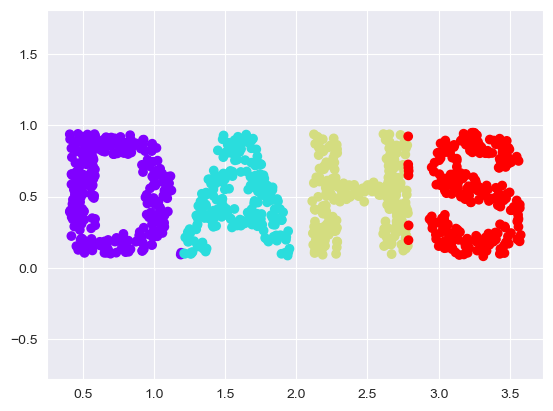

In [3]:
X = make_dahs(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 4))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

In [4]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

# PCA -Dimensionality reduction
- 간단한 예시를 통한 pca 구현

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

(-2.7292712056271964,
 2.5702744393352615,
 -0.9326181575178751,
 1.004413830229183)

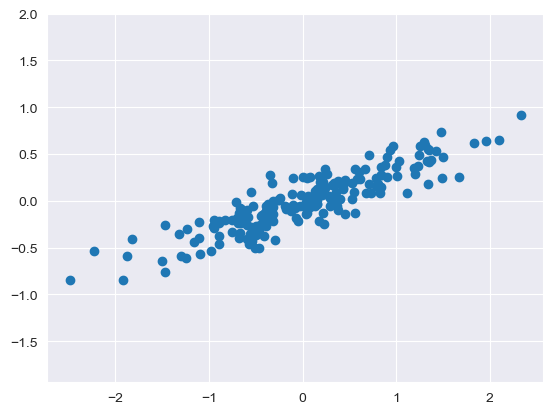

In [6]:
#Random data 생성
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:,0], X[:, 1])
plt.axis('equal')

## 1. Scaling
- PCA의 목적 : Maximize the variance V after projection
- $Max   w^\top S w$

(-3.3534087054527717,
 3.079070151762556,
 -2.9610077757452697,
 3.2159825436132246)

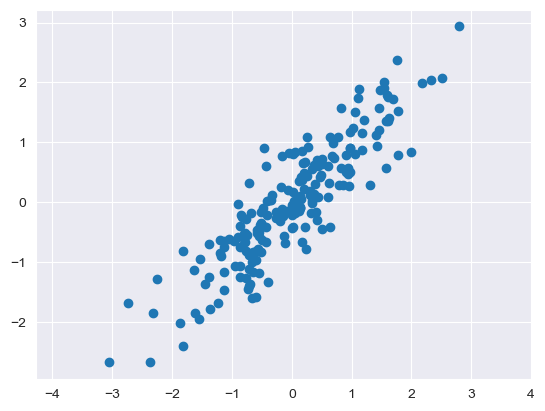

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
plt.scatter(X_std[:,0], X_std[:, 1])
plt.axis('equal')

## 2.공분산 행렬 구하기

In [8]:
features = X_std.T #공분산 계산을 위한 transpose
cov_matrix = np.cov(features) # 공분산을 구하는 np.cov 사용
cov_matrix

array([[1.00502513, 0.89385925],
       [0.89385925, 1.00502513]])

## 3. 고유값(Eigenvalues)과 고유벡터(Eigenvector) 구하기

In [9]:
import numpy.linalg as lin
eigenvalues = lin.eig(cov_matrix)[0]  #numpy.lin의 eig함수를 이용하여 고유값 계산
eigenvectors = lin.eig(cov_matrix)[1] #numpy.lin의 eig함수를 이용하여 고유벡터 계산

print(eigenvalues)
print(eigenvectors)

[0.11116588 1.89888438]
[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]


In [10]:
mat = np.zeros((2,2))
mat[0][0] = eigenvalues[0]
mat[1][1] = eigenvalues[1]
mat

array([[0.11116588, 0.        ],
       [0.        , 1.89888438]])

## 4.고유값 분해의 곱으로 원래 공분산 행렬 구하기

In [11]:
pca_components = np.dot(np.dot(eigenvectors,mat),eigenvectors.T) #행렬곱 dot을 이용, 고유값 분해 곱으로 공분산 구함
pca_components

array([[1.00502513, 0.89385925],
       [0.89385925, 1.00502513]])

## 고유 백터 축으로 값 변환

In [12]:
def new_coordinates(X,eigenvectors):
    for i in range(eigenvectors.shape[0]):
        if i == 0:
            new = [X.dot(eigenvectors.T[i])]
        else:
            new = np.concatenate((new,[X.dot(eigenvectors.T[i])]),axis=0)
    return new.T
#X, eigenvector 행렬곱을 통해 데이터를 projection

# 모든 고유 벡터 축으로 데이터를 projection한 값입니다

In [13]:
pca =new_coordinates(X_std,eigenvectors)

## PCA 함수 구현(종합)
- 지금까지 위에서 구현한 PCA를 함수화 시켜보겠습니다.

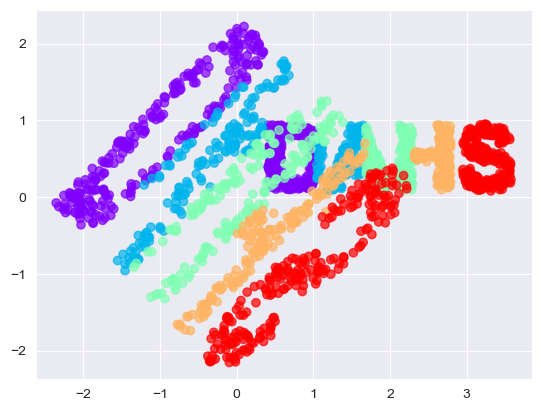

In [14]:
from pca import MYPCA
import numpy as np
X = make_dahs(1000)
X_new = MYPCA(X,2)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], alpha=0.7,**colorize)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.7, **colorize)
plt.axis('equal');

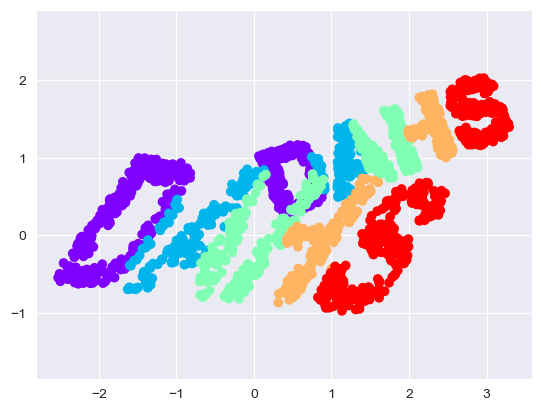

In [15]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20)
X_new = MYPCA(X2,2)
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.scatter(X_new[:, 0], X_new[:, 1], **colorize)
plt.axis('equal');

# 다차원 척도법(MDS, multidimensional Scaling)
- 사실 x와 y값이 근본적으로 중요하지 않고 PCA와 같은 선형변환으로도 보존된다는 것은 위의 그림으로도 확인 가능하다.
- 따라서 MDS는 이러한점에 착안하여 더 근본적인 데이터세트 점과 점 사이의 거리에 초점을 맞추는 거리 행렬을 사용한다.

In [16]:
from mds import MDS, landmark_MDS

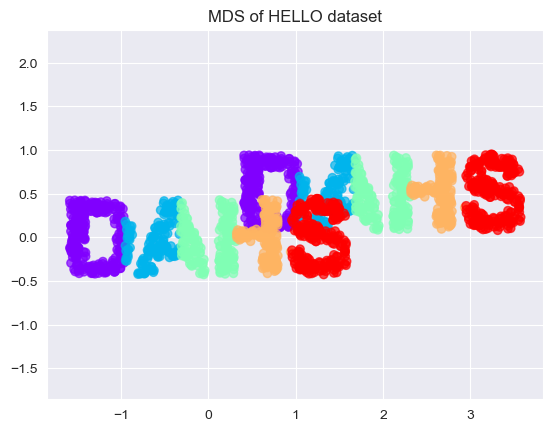

In [17]:
X_new = MDS(D,dim=2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, **colorize)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.7, **colorize)
plt.title('MDS of HELLO dataset')

plt.axis('equal');

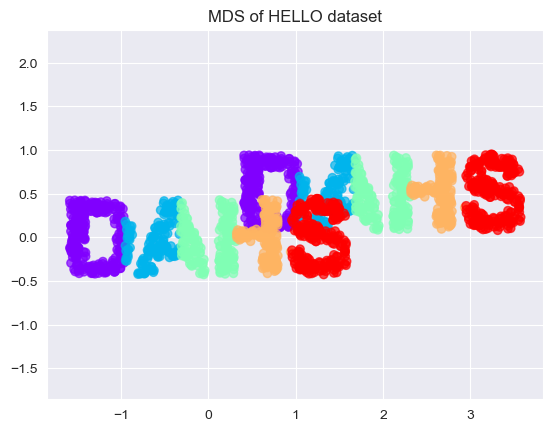

In [18]:
X_new = MDS(D,dim=2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, **colorize)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.7, **colorize)
plt.title('MDS of HELLO dataset')

plt.axis('equal');

## PCA 및 MDS 알고리즘의 한계

In [19]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

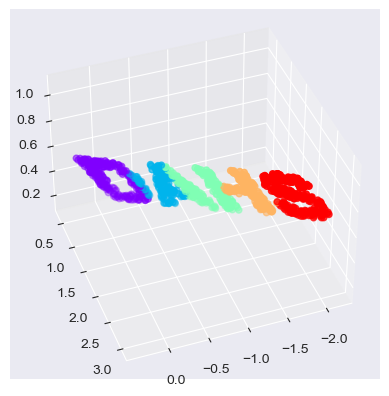

In [20]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=40)

# 3차원 -> 2차원 MDS

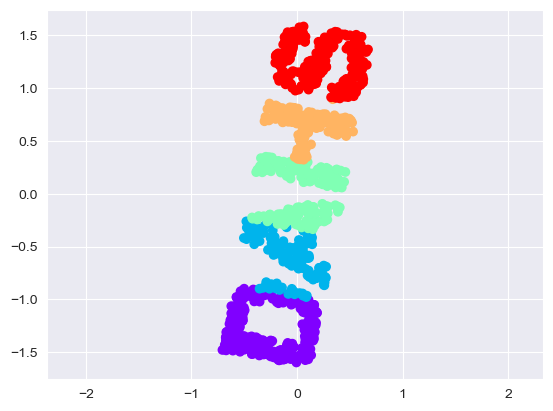

In [21]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

## 비선형적 관계 3차원 데이터 - Manifold learning
- 해당 그림을 통헤 3차원 데이터는 2차원 데이터로 MDS를 통해 임베딩 됨을 확인할 수 있었다.

In [24]:
def make_dahs_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_dahs_s_curve(X)

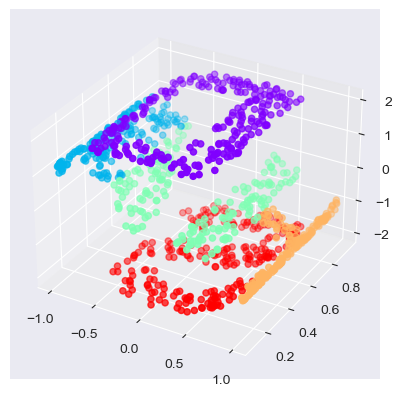

In [25]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

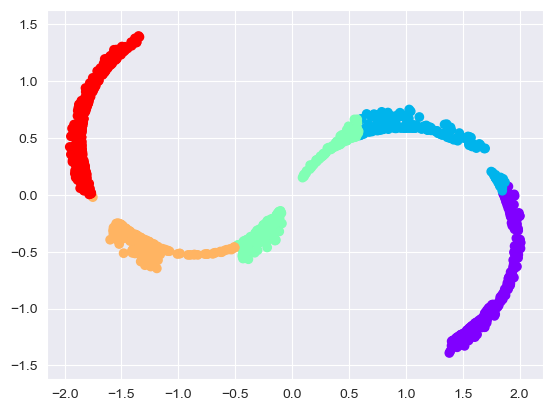

In [26]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

위의 그림은 3차원 공간에서의 데이터 특징을 2차원에서 임베딩 되지 못했음을 확인할수 있EK. -> 3차원 데이터가 비선형적으로 구성되어 있고 MDS는 이를 캐치하지 못함

# 비선형적 차원축소 방법 소개
- 선형적인 차원 축소 알고리즘인 PCA, MDS는 비선형적인 관계를 포착하지 못함
- 비선형적인 차원 축소 알고리즘 : LLE, ISOMAP, T-SNE
- 위 3가지 알고리즘의 간단한 구현을 Sklearn을 통해 구현
- LLE : 주변 데이터의 거리만 보존하기 때문에 성공적으로 2차원에서 임베딩 됨
- ISOMAP : 모든 데이터의 최단거리를 최적화하기 때문에 2차원에서 거리 정보를 보존하지 못함
- t-SNE

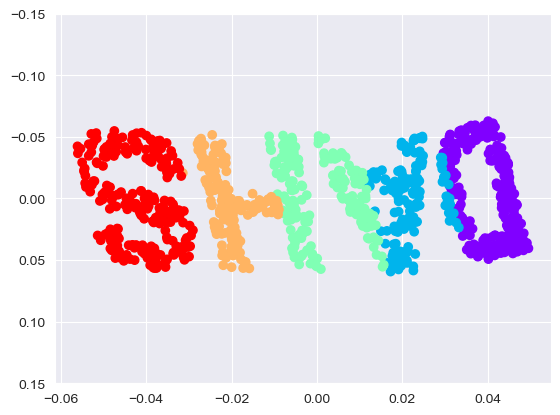

In [27]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

C:\Users\kimhongbum\anaconda3\envs\BA_Tutorial\lib\site-packages\sklearn\manifold\_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\kimhongbum\anaconda3\envs\BA_Tutorial\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\kimhongbum\anaconda3\envs\BA_Tutorial\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\kimhongbum\anaconda3\envs\BA_Tutorial\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix

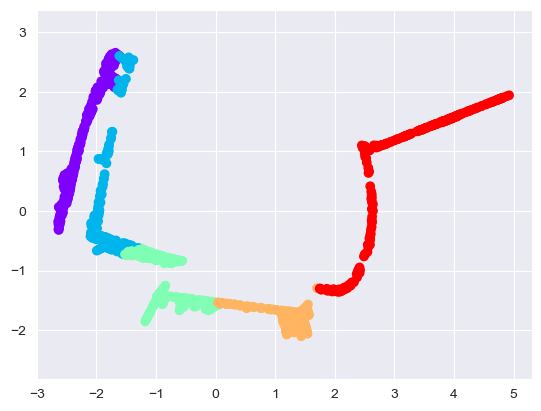

In [28]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(XS)
plt.scatter(proj[:, 0], proj[:, 1], **colorize)
plt.axis('equal');

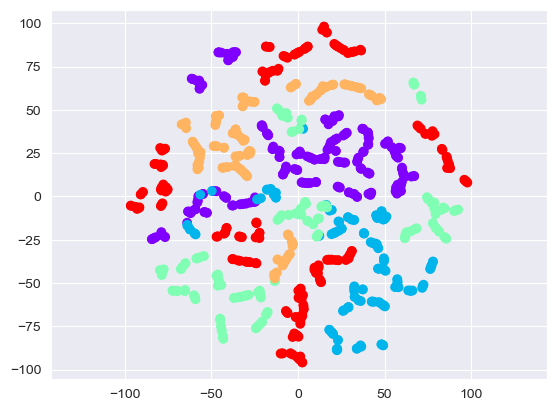

In [30]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
tsne = model.fit_transform(XS)
plt.scatter(tsne[:, 0], tsne[:, 1], **colorize)
plt.axis('equal');